## The dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from pathlib import Path

%matplotlib inline

Download the data

```bash
wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip
unzip -d cells data.zip
```

In [2]:
from scipy.ndimage.morphology import binary_fill_holes
from scipy.ndimage import zoom


def load_data(subset):
    images, masks = [], []
    for file in (Path('cells/BBBC018_v1_images-fixed/') / subset).iterdir():
        mask_name = file.name[:5] + '-cells.png'
        
        x = np.array(imageio.imread(file))
        y = np.array(imageio.imread(Path('cells/BBBC018_v1_outlines/') / subset / mask_name))
        y = binary_fill_holes(y > 0)
        
        x = x[::4, ::4] # use zoom instead
        y = y[::4, ::4]
        

        x = np.moveaxis(x.astype('float32'), -1, 0)
        y = y.astype('float32')[None]
        
        images.append(x)
        masks.append(y)
    
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

In [3]:
images, masks = load_data('train')

In [4]:
{x.shape for x in images}

{(3, 128, 128)}

In [5]:
x, y = images[0], masks[0]

In [6]:
y.shape

(1, 128, 128)

In [7]:
x.dtype, y.dtype

(dtype('float32'), dtype('float32'))

In [8]:
np.unique(y)

array([0., 1.], dtype=float32)

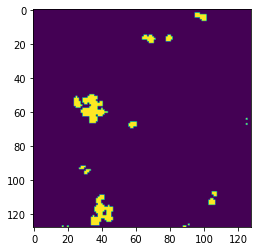

In [9]:
plt.imshow(y[0])

## A fully convolutional architecture

In [13]:
import torch
from torch import nn

In [14]:
device = 'cuda'

In [15]:
def down_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.MaxPool2d(2),
    )


def up_block(in_channels, out_channels):
    return nn.Sequential(
        nn.UpsamplingBilinear2d(scale_factor=2),
        
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),        
    )

In [16]:
# unet is far better suited for this task
#  but this model is simpler
model = nn.Sequential(
    down_block(3, 32),
    down_block(32, 64),
    down_block(64, 128),
    down_block(128, 256),
    
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(),
    
    up_block(512, 256),
    up_block(256, 128),
    up_block(128, 64),
    up_block(64, 32),
    
    nn.Conv2d(32, 1, kernel_size=1),
).to(device)

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Training

We'll use borders weighting, which will increase segmentation quality for border pixels

In [10]:
from scipy.ndimage import distance_transform_edt

In [11]:
def make_weights(mask, max_weight=10, min_weight=1):
    mask = mask.astype(bool)
    return np.maximum(
        min_weight, 
        max_weight + 1 - distance_transform_edt(mask) - distance_transform_edt(~mask)
    )

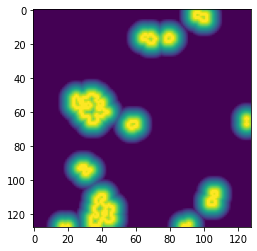

In [12]:
plt.imshow(make_weights(y)[0])

In [18]:
def get_random_batch(size):
    indices = np.random.randint(0, len(images), size=size)
    
    xs, ys = images[indices], masks[indices]
    weights= np.array(list(map(make_weights, ys)))
    
    xs = torch.from_numpy(xs).to(device)
    ys = torch.from_numpy(ys).to(device)
    weights = torch.from_numpy(weights).to(device)
    return xs, ys, weights


# small helper that moves torch tensors back to numpy
def to_np(x):
    return x.data.cpu().numpy()

In [19]:
# setting the model to train mode which is default, 
# but this is a good habit if you plan to interchange
# training and evaluation
model = model.train()

for i in range(10_000):
    image_batch, mask_batch, weights = get_random_batch(3)
    
    # calculate loss
    pred = model(image_batch)
    # numerically stable version of logloss
    loss = nn.functional.binary_cross_entropy_with_logits(pred, mask_batch, weight=weights)
    
    # pytorch magic
    optimizer.zero_grad()
    # calculate the gradient
    loss.backward()
    # make a step to minimize the loss
    optimizer.step()
    
    print(loss.item(), end='\r')

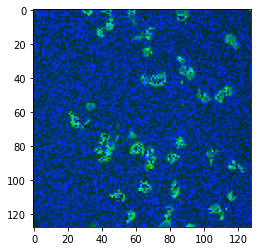

In [20]:
plt.imshow(np.moveaxis(to_np(image_batch[0]), 0, -1).astype('uint8'))

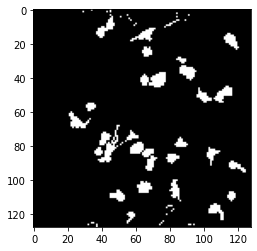

In [21]:
plt.imshow(to_np(mask_batch[0, 0]), cmap='gray')

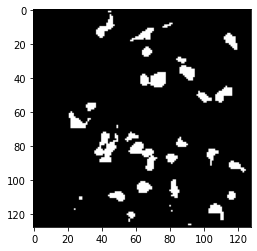

In [22]:
plt.imshow(to_np(torch.sigmoid(pred[0, 0])) >= 0.5, cmap='gray')

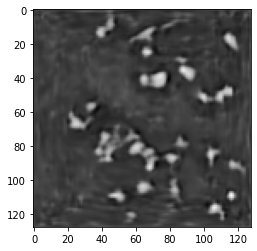

In [23]:
plt.imshow(to_np(pred[0, 0]), cmap='gray')

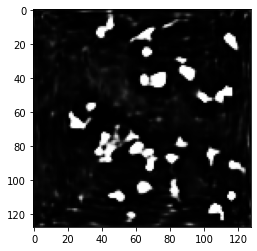

In [24]:
plt.imshow(to_np(torch.sigmoid(pred[0, 0])), cmap='gray')

In [25]:
from tqdm.notebook import tqdm

def evaluate(images, masks):
    model.eval()
    
    results = []
    for image in tqdm(images):
        image = torch.from_numpy(image.astype('float32')).to(device)
        pred = model(image[None]).cpu().data.numpy()
        pred = pred[0] >= 0.5
        
        results.append(pred)
        
    results = np.array(results)
    masks = np.array(masks, bool)
    
    intersection = results & masks
    union = results | masks
    
    iou = intersection.sum((1, 2, 3)) / union.sum((1, 2, 3))
    return iou.mean()

In [26]:
evaluate(images, masks)

0.9095810494967329

In [27]:
evaluate(*load_data('val'))

0.3355611969767343